### Word2Ver的skip-gram模式


![img](data/image/Word2Vec.jpg)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#### 创建一个简单的数据集 用于验证简单的Skip-Gram模型

In [2]:
sentences = [
    'Kage is Teacher',
    'Mazong is Boss',
    'Niuzong is Boss',
    'Xiaobing is Student',
    'Xiaoxue is Student'
]
words = ' '.join(sentences).split()
wordlist = list(set(words))
word_to_index = {word:index for index, word in enumerate(wordlist)}
index_to_word = {index:word for index, word in enumerate(wordlist)}
voc_size = len(wordlist)

#### 生成 skip-gram 数据集

In [3]:
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx-window_size, 0):min(idx+window_size+1, len(sentence))]:
                if neighbor != word:
                    data.append((neighbor, word))
    return data

In [4]:
skipgram_data = create_skipgram_dataset(sentences)

In [5]:
skipgram_data[:3]

[('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]

#### 进行one-hot编码

In [6]:
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

In [7]:
word_to_index

{'is': 0,
 'Student': 1,
 'Teacher': 2,
 'Xiaoxue': 3,
 'Niuzong': 4,
 'Xiaobing': 5,
 'Kage': 6,
 'Boss': 7,
 'Mazong': 8}

In [8]:
one_hot_encoding('Teacher', word_to_index)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.])

#### 定义skip-gram类型

In [9]:
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        self.input_to_hidden = nn.Linear(voc_size,embedding_size,bias = False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias = False)
        
    def forward(self, x):
        #[batch_size, voc_size] -> [batch_size, embedding_size]
        hidden = self.input_to_hidden(x)
        # [batch_size, embedding_size]->[batch_size, voc_size]
        output = self.hidden_to_output(hidden)
        return output

In [19]:
class SkipGramEmbedding(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGramEmbedding, self).__init__()
        self.embedding = nn.Embedding(voc_size, embedding_size)
        # self.input_to_hidden = nn.Linear(voc_size,embedding_size,bias = False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias = False)
        
    def forward(self, x):
        #[batch_size, voc_size] -> [batch_size, embedding_size]
        hidden = self.embedding(x)
        # [batch_size, embedding_size]->[batch_size, voc_size]
        output = self.hidden_to_output(hidden)
        return output

In [10]:
emb = nn.Embedding(9, 2)

In [13]:
x = torch.tensor([[0,4,3,2],[1,2,3,4]])
emb(x).shape

torch.Size([2, 4, 2])

#### 训练skipGram模型

In [37]:
learning_rate = 0.001
epochs = 1000
skipgram_model = SkipGram(voc_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(), lr = learning_rate)

loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for context, target in skipgram_data:
        x = one_hot_encoding(target, word_to_index).float().unsqueeze(0)
        y_true = torch.tensor([word_to_index[context]], dtype=torch.long)
        y_pred = skipgram_model(x)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1}, Loss:{loss_sum / len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))
        


Epoch:100, Loss:2.1822559158007304
Epoch:200, Loss:2.1475614349047345
Epoch:300, Loss:2.103223081429799
Epoch:400, Loss:2.0444663643836973
Epoch:500, Loss:1.9749744296073914
Epoch:600, Loss:1.9100400686264039
Epoch:700, Loss:1.8633092204729715
Epoch:800, Loss:1.833313806851705
Epoch:900, Loss:1.8121854345003763
Epoch:1000, Loss:1.794832855463028


#### 训练skipGram模型 Embedding 版

In [24]:
learning_rate = 0.001
epochs = 10000
skipgram_model_emb = SkipGramEmbedding(voc_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=skipgram_model_emb.parameters(), lr=learning_rate)
loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for context, word in skipgram_data:
        x = torch.tensor([word_to_index[context]],dtype=torch.long)
        y_true = torch.tensor([word_to_index[word]], dtype=torch.long)
        y_pred = skipgram_model_emb(x)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1}, Loss:{loss_sum / len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))


Epoch:100, Loss:2.079574370384216
Epoch:200, Loss:2.031510857741038
Epoch:300, Loss:1.9952849586804708
Epoch:400, Loss:1.9667276859283447
Epoch:500, Loss:1.9438509444395702
Epoch:600, Loss:1.9249318778514861
Epoch:700, Loss:1.908656257390976
Epoch:800, Loss:1.894148164987564
Epoch:900, Loss:1.8808275580406189
Epoch:1000, Loss:1.8682923078536988
Epoch:1100, Loss:1.8562466859817506
Epoch:1200, Loss:1.844468100865682
Epoch:1300, Loss:1.832792846361796
Epoch:1400, Loss:1.8211134533087412
Epoch:1500, Loss:1.8093795319398245
Epoch:1600, Loss:1.7975967148939769
Epoch:1700, Loss:1.785822606086731
Epoch:1800, Loss:1.77415531873703
Epoch:1900, Loss:1.7627168814341228
Epoch:2000, Loss:1.751633757352829
Epoch:2100, Loss:1.7410189350446066
Epoch:2200, Loss:1.7309589385986328
Epoch:2300, Loss:1.7215075174967447
Epoch:2400, Loss:1.7126866141955057
Epoch:2500, Loss:1.7044918338457744
Epoch:2600, Loss:1.69689937432607
Epoch:2700, Loss:1.6898745278517404
Epoch:2800, Loss:1.6833756109078726
Epoch:2900, L

In [31]:
# 查看embedding向量

skipgram_model_emb.embedding.weight

Parameter containing:
tensor([[-1.1009,  1.0087],
        [ 0.4891, -0.5022],
        [ 1.6869, -0.3140],
        [-1.1073, -2.1590],
        [-0.4129, -1.1940],
        [-1.1442, -2.2140],
        [-1.6217, -3.0540],
        [ 3.5218, -0.3147],
        [-0.4116, -1.1925]], requires_grad=True)

#### 画出loss图片

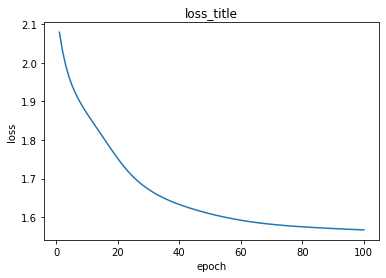

In [26]:
# plt.rcParams["font.family"] = ['SimHei']
# plt.rcParams["font.sans-serif"] = ['SimHei']
plt.rcParams["axes.unicode_minus"] = False
plt.plot(range(1, epochs//100 + 1), loss_values)
plt.title("loss_title")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### 输出学习到的词向量

In [69]:
weight = skipgram_model.input_to_hidden.weight.detach().numpy()
for word, idx in word_to_index.items():
    print(word, weight[:, idx])

Niuzong [ 0.65769047 -0.26466107]
Teacher [ 0.14655927 -0.7789605 ]
is [-0.43320093  0.3179107 ]
Boss [ 0.30376348 -0.8967997 ]
Xiaobing [ 0.42115295 -1.0312868 ]
Student [ 1.3189254  -0.08067948]
Kage [ 0.47978416 -0.19884777]
Xiaoxue [ 0.42179698 -1.0321187 ]
Mazong [ 0.56012803 -0.31129205]


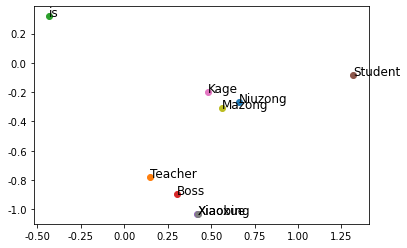

In [72]:
fig,ax = plt.subplots()
for word, idx in word_to_index.items():
    vec = skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()
    ax.scatter(vec[0],vec[1])
    ax.annotate(word, (vec[0], vec[1]), fontsize=12)